# Process GM-SEUS Installation Results and Validate

# Import Libraries and Variables

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import os 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Load config file
def load_config(filename):
    config = {}
    with open(filename, 'r') as f:
        for line in f:
            # Strip whitespace and split by '='
            key, value = line.strip().split('=')
            # Try to convert to numeric values if possible
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  # Leave as string if not a number
            config[key] = value
    return config

In [7]:
# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
downloaded_path = os.path.join(wd, r'Data\Downloaded')
derived_path = os.path.join(wd, r'Data\Derived')
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')
figure_path = os.path.join(wd, r'Figures')

# Set LandTrendr file paths
lt_folder = os.path.join(derived_path, r'LandTrendrGEEInstallYear')

# Set a final gmseus arrays and panel path
gmseusArraysFinalPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Arrays_Final.shp')
gmseusPanelsFinalPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_Panels_Final.shp')

# Set all other paths
ccvpvInitArraysPath = os.path.join(downloaded_path, r'SolarDB\CCVPV\PV_ID_CV.shp')

# Load the config from the text file
config = load_config('config.txt')

# Load variables
overlapDist = config['overlapDist'] # 190 meters, Set a overlap distance for checking if points/mismatched geometries between Solar PV datasets are duplicates
minPanelRowArea = config['minPanelRowArea'] # 15 m2, minimum area for a single panel row from the 1st percentile panel area from Stid et al., 2022
maxPanelRowArea = config['maxPanelRowArea'] # 254 m2 95th perccentile for a single panel row from Stid et al., 2022. MSU Solar Carport has max 1890m2
minNumPanelRows = config['minNumPanelRows'] # 3 panels, minimum number of panels rows to form a ground mounted solar array, definition from Stid et al., 2022
minPmArRatio = config['minPmArRatio'] # 18.8%, 20% was minimum ratio of panel perimeter to area ratio for panels from Stid et al., 2022, MSU Solar Carport has min 18.9%
panelArrayBuff = config['panelArrayBuff'] # 10m buffer, 20m maximum distance between panel rows to form an array. We used 5m in Stid et al., 2022, but there are lower packing factors at greater latitudes (nativeID: '1229957948')
arrayArrayBuff = config['arrayArrayBuff'] # 20m buffer, 40m maximum distance between arrays subsections of the same mount type to form a complete array. In Stid et al., 2022, we used 50m, but we checked for same installation year in addition to mount type.
lengthRatioThresh = config['lengthRatioThresh']  # If length ratio < 3.0, set to dual_axis or else fixed_axis_diagonal, else single- or fixed-axis
areaRatioThresh = config['areaRatioThresh']  # If area ratio < 0.15, set to fixed_diag_axis, else dual_axis

# Helper Functions

In [8]:
# Define a function to calculate the intersection over union of any two gdf datasets accounting for multiple potential intersections
def getIoU(gdf1, gdf2, panelRows = False):

    # If panelRows is false, explode, dissolve, and explode arrays
    if panelRows == False:
        # Explode both datasets into polygons, dissolve overlapping geometries, and explode again into spatially unique polygons
        gdf1 = gdf1.explode(index_parts=False).reset_index(drop=True)
        gdf2 = gdf2.explode(index_parts=False).reset_index(drop=True)
        gdf1 = gdf1.dissolve().reset_index(drop=True)
        gdf2 = gdf2.dissolve().reset_index(drop=True)
        gdf1 = gdf1.explode(index_parts=False).reset_index(drop=True)
        gdf2 = gdf2.explode(index_parts=False).reset_index(drop=True)
        # If panelRows is false, set minArrayArea to 45 square meters, else set to 15 square meters
        minArea = 45 # 45 square meters
    else:
        # If panelRows is true, set minArrayArea to 15 square meters
        minArea = 15 # 15 square meters

    # Drop all resulting polygons less than minArea
    gdf1['origArea_1'] = gdf1['geometry'].area
    gdf2['origArea_2'] = gdf2['geometry'].area

    # Drop all resulting polygons less than minArrayArea
    gdf1 = gdf1[gdf1['origArea_1'] > minArea].reset_index(drop=True)
    gdf2 = gdf2[gdf2['origArea_2'] > minArea].reset_index(drop=True)

    # Add a tempIOUid column to both datasets that is the index
    gdf1['tempIOUid_1'] = range(0, len(gdf1))
    gdf2['tempIOUid_2'] = range(0, len(gdf2))

    # Spatial join the two datasets, copying the tempIOUid_2 column to the gdf1 dataset
    intersections = gpd.sjoin(gdf1[['geometry', 'tempIOUid_1']], gdf2[['geometry', 'tempIOUid_2']], how='inner', predicate='intersects')

    # Perform the intersection operation to get the actual intersection geometries
    intersections['geometry'] = intersections.apply(lambda row: gdf1.loc[row['tempIOUid_1'], 'geometry'].intersection(gdf2.loc[row['tempIOUid_2'], 'geometry']), axis=1)

    # Now dissolve intersections by tempIOUid_1 and tempIOUid_2. 
    intersections = intersections.dissolve(by=['tempIOUid_1'], aggfunc='sum').reset_index()
    intersections = intersections.dissolve(by=['tempIOUid_2'], aggfunc='sum').reset_index()

    # Set an index column
    intersections['intIndex'] = intersections.index

    # Spatially join intersections to gdf1 and gdf2 saving intIndex
    gdf1 = gpd.sjoin(gdf1, intersections[['intIndex', 'geometry']], how='left', predicate='intersects')
    gdf2 = gpd.sjoin(gdf2, intersections[['intIndex', 'geometry']], how='left', predicate='intersects')

    # Drop rows from both where intIndex is NaN
    gdf1 = gdf1.dropna(subset=['intIndex'])
    gdf2 = gdf2.dropna(subset=['intIndex'])

    # Drop any columns containing the substring 'index'
    gdf1 = gdf1.loc[:, ~gdf1.columns.str.contains('index')]

    # Calculate areas and IoU
    gdf1['areaA'] = gdf1['geometry'].area
    gdf2['areaB'] = gdf2['geometry'].area

    # Aggregate areas for each intIndex
    gdf1_agg = gdf1.groupby('intIndex')['areaA'].sum().reset_index()
    gdf2_agg = gdf2.groupby('intIndex')['areaB'].sum().reset_index()

    # Merge aggregated areas into intersections
    intersections = intersections.merge(gdf1_agg, on='intIndex', how='left')
    intersections = intersections.merge(gdf2_agg, on='intIndex', how='left')

    # Calculate intersectionArea and unionArea
    intersections['intersectionArea'] = intersections['geometry'].area
    intersections['unionArea'] = (
        intersections['areaA'] +
        intersections['areaB'] -
        intersections['intersectionArea'])

    # Calculate IoU
    intersections['IoU'] = intersections['intersectionArea'] / intersections['unionArea']

    # Calculate the proportional difference in area between the two areas
    intersections['propDiff'] = (intersections['areaB'] - intersections['areaA']) / intersections['areaA']
    return intersections

# Function to check for and remove erroneous geometries in arrays
def checkArrayGeometries(arrays): 
    # For a collection of reasons, array boundaries may contain erroneous geometries that result in a near-zero area, linestrings, or points. 
    # To check for and remove these, we'll explode arrays, calculate a temporary area, remove subarrays that are less than a minimum area, then dissolve by tempID.
    arrays['tempDissolveID'] = (1 + np.arange(len(arrays)))  # Create a temporary ID for dissolving
    arrays = arrays.explode(index_parts=False)
    arrays['tempArea'] = arrays['geometry'].area
    arrays = arrays[arrays['tempArea'] >= minPanelRowArea]
    arrays = arrays.dissolve(by=['tempDissolveID'], as_index=False)
    arrays = arrays.drop(columns=['tempArea', 'tempDissolveID'])
    arrays = arrays.reset_index(drop=True)
    return arrays

# Function to create an array from a set of panel rows based on the distance between them
def createArrayFromPanels(panels, buffDist, dissolveID, areaID='area'):
 
    # Count panels per group before dissolving
    panelCounts = panels.groupby(dissolveID).size().reset_index(name='numPanels')

    # Get the total area of the panels within each group (sum of area column). 
    panelAreas = panels.groupby(dissolveID)[areaID].sum().reset_index(name='pnlArea')
    
    # Buffer the geometries by buffDist, dissovle boundaries, and unbuffer by buffDist* -1. Assign the number of objects being dissovle into a numPanels column.
    arrays = panels.copy()
    arrays['geometry'] = arrays.buffer(buffDist)
    arrays = arrays.dissolve(by=[dissolveID], as_index=False)
    arrays['geometry'] = arrays.buffer(buffDist * -1)

    # Merge the panel counts and panel areas back into the dissolved array DataFrame. Select only the dissolveID and respective columns in the right df
    arrays = arrays.merge(panelCounts[[dissolveID, 'numPanels']], on=dissolveID, how='left')
    arrays = arrays.merge(panelAreas[[dissolveID, 'pnlArea']], on=dissolveID, how='left')

    # Due to the buffering and unbuffering, some mulitpolygons contain erroneous geometries that result in a near-zero area, linestrings, or points. Remove these.
    arrays = checkArrayGeometries(arrays)

    # Reset index
    arrays = arrays.reset_index(drop=True)
    return arrays

# Get Manuscript Numeric Outputs

In [9]:
# Call gmseus arrays and panels
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)
gmseusPanels = gpd.read_file(gmseusPanelsFinalPath)

## Abstract

In [10]:
# Print total number of arrays and panels
print('Total number of arrays: ', len(gmseusArrays))
print('Total number of panels: ', len(gmseusPanels))

# Print total area of arrays and panels (convert to km2)
print('Total area of arrays: ', gmseusArrays['totArea'].sum()/1e6)
print('Total area of panels: ', gmseusPanels['rowArea'].sum()/1e6)

# Print total sum of array capacity (convert from MW to GW)
print('Total sum of array capacity: ', gmseusArrays['capMW'].sum()/1e3)

Total number of arrays:  14926
Total number of panels:  2919392
Total area of arrays:  2870.1942769654306
Total area of panels:  466.32854158999993
Total sum of array capacity:  182.37899452000002


## Background & Summary

In [30]:
# Print total number of arrays and sum array capacity for arrays with capacity > 1 (convert from MW to GW)
print('Total number of utility-scale arrays', len(gmseusArrays[gmseusArrays['capMW'] >= 1]))
print('Total sum of utility-scale array capacity: ', gmseusArrays[gmseusArrays['capMW'] >= 1]['capMW'].sum()/1e3)

# Print total number of arrays and sum array capacity for arrays with capacity < 1 (convert from MW to GW)
print('Total number of commercial-scale arrays', len(gmseusArrays[gmseusArrays['capMW'] < 1]))
print('Total sum of commercial-scale array capacity: ', gmseusArrays[gmseusArrays['capMW'] < 1]['capMW'].sum()/1e3)

# Print total number of arrays where numRow > 0 and total sum of array capacity (convert from MW to GW)
print('Total number of arrays with panel-rows: ', len(gmseusArrays[gmseusArrays['numRow'] > 0]))
print('Total sum of array capacity with panel-rows: ', gmseusArrays[gmseusArrays['numRow'] > 0]['capMW'].sum()/1e3)

# Print sum of gmseusPanel areas (convert to km2)
print('Total sum of panel areas: ', gmseusPanels['rowArea'].sum()/1e6)

# Print mount types and proportion of total array using using gmseusArrays, and consider any mount type containing the string 'mixed', as mixed (sum these in the proportiona) -- do not use append, use pd.concat
mountTypes = gmseusArrays['mount'].value_counts(normalize=True)
mixed_proportion = mountTypes[mountTypes.index.str.contains('mixed')].sum()
mountTypes = pd.concat([pd.Series({'mixed': mixed_proportion}), mountTypes[~mountTypes.index.str.contains('mixed')]])
mountTypes = mountTypes.sort_values(ascending=False)
print(mountTypes)

# Print median GCR1 values for each mount type where numRows > 0, considering all mixed mount types as mixed. Have to check numRows because we extrapolate GCR1 values for arrays with numRows = 0
mountGCR1 = gmseusArrays[gmseusArrays['numRow'] > 0].groupby('mount')['GCR1'].median()
mixedGCR1 = gmseusArrays[gmseusArrays['mount'].str.contains('mixed')]['GCR1'].median()
mountGCR1 = pd.concat([pd.Series({'mixed': mixedGCR1}), mountGCR1[~mountGCR1.index.str.contains('mixed')]])
mountGCR1 = mountGCR1.sort_values(ascending=False)
print(mountGCR1)

Total number of utility-scale arrays 9588
Total sum of utility-scale array capacity:  180.37540569851873
Total number of commercial-scale arrays 5338
Total sum of commercial-scale array capacity:  2.003588821481233
Total number of arrays with panel-rows:  8964
Total sum of array capacity with panel-rows:  80.02172115299582
Total sum of panel areas:  466.32854158999993
fixed_axis     0.419603
unknown        0.326879
single_axis    0.207825
mixed          0.024655
dual_axis      0.021037
dtype: float64
mixed          0.65835
dual_axis      0.59080
fixed_axis     0.53290
single_axis    0.41845
dtype: float64


## Methods

In [35]:
# Print total number of arrays where Source == "GMSEUSgeorect"
print('Total number of arrays from GMSEUSgeorect: ', len(gmseusArrays[gmseusArrays['Source'] == 'GMSEUSgeorect']))

# Print the value counts for gmseusPanels Source
print(gmseusPanels['Source'].value_counts())

# Print the total number of arrays with newBound = 1, and the sum of the totArea for these arrays
print('Total number of arrays with newBound = 1: ', len(gmseusArrays[gmseusArrays['newBound'] == 1]))
print('Total sum of totArea for arrays with newBound = 1: ', gmseusArrays[gmseusArrays['newBound'] == 1]['totArea'].sum()/1e6)

# Call exisintArrayShapes, get existing arrays that intersect with gmseusArrays where newBound = 1
existingArrayShapes = gpd.read_file(os.path.join(derivedTemp_path, r'existingDatasetArrayShapes.shp'))
existingArrayShapesOldBounds = gpd.sjoin(existingArrayShapes, gmseusArrays[gmseusArrays['newBound'] == 1], how='left', predicate='intersects')
existingArrayShapesOldBounds = existingArrayShapesOldBounds.dropna(subset=['index_right'])
existingArrayShapesOldBounds = existingArrayShapesOldBounds.reset_index(drop=True)
print('Sum of area for existing arrays with newBound = 1: ', existingArrayShapesOldBounds['area'].sum()/1e6)

Total number of arrays from GMSEUSgeorect:  34
Source
gmseus    1848306
OSM        867999
CCVPV      203087
Name: count, dtype: int64
Total number of arrays with newBound = 1:  4990
Total sum of totArea for arrays with newBound = 1:  145.35201
Sum of area for existing arrays with newBound = 1:  318.33109712049855


## Technical Validation

# Technical Validation

## LandTrendr Installation Year

f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Number of arrays with a newly detected installation year: 4153
Mean Absolute Error: 1.529496749337828


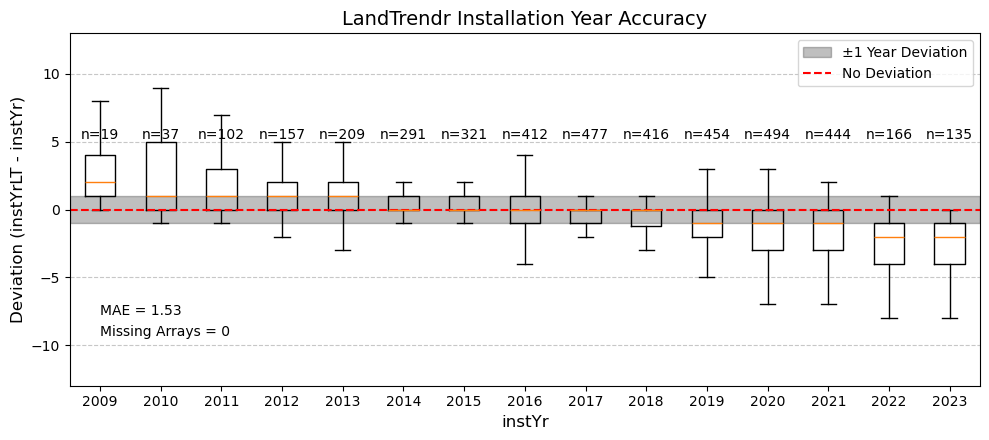

In [53]:
# Call gmseusArrays
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Set plot df (Source 'USPVDB' or 'CCVPV')
plotdf = gmseusArrays[gmseusArrays['Source'].isin(['USPVDB'])]

# Calculate the deviation
plotdf['deviation'] = plotdf['instYrLT'] - plotdf['instYr']

# Remove any rows where instYrLT is -9999 or instYr is -9999
lt_data_noNull = plotdf[(plotdf['instYrLT'] != -9999) & (plotdf['instYr'] != -9999)]

# Drop rows where Source is anything other than USPVDB
lt_data_noNull = lt_data_noNull[lt_data_noNull['Source'] == 'USPVDB']

# Print the total number of arrays with a newly detected installation year
print('Number of arrays with a newly detected installation year:', lt_data_noNull['deviation'].value_counts().sum())

# Print the mean absolute deviation
print('Mean Absolute Error:', lt_data_noNull['deviation'].abs().mean())

# Create a list of deviation values grouped by instYr and count the number of data points in each group
data = [lt_data_noNull[lt_data_noNull['instYr'] == year]['deviation'] for year in range(2009, 2024)]
counts = [len(group) for group in data]

# Plot the boxplot without showing outliers
plt.figure(figsize=(10, 4.5))
# Add a shaded black (alpha = 0.25) that is plus or minus 1 year from the 0 line
plt.axhspan(-1, 1, color='black', alpha=0.25, label='±1 Year Deviation')

# Create the boxplot
plt.boxplot(data, positions=range(2009, 2024), widths=0.5, showfliers=False)

# Add the count (N) above each box
for i, count in enumerate(counts):
    plt.text(2009 + i, 5, f'n={count}', ha='center', va='bottom', fontsize=10)

# In the lower left corner, add the MAE and the difference between lt_data nrows with instYr and instYrLT values not equal to -9999 and source USPVDB, and the nrows of lt_data_noNull
plt.text(2009, -7, f'MAE = {lt_data_noNull["deviation"].abs().mean():.2f}', ha='left', va='top', fontsize=10)
plt.text(2009, -8.5, f'Missing Arrays = {plotdf[(plotdf['instYr'] != -9999) & (plotdf["Source"] == "USPVDB")].shape[0] - lt_data_noNull.shape[0]}', ha='left', va='top', fontsize=10)

# Set x and y limits
plt.xlim(2008.5, 2023.5)
plt.ylim(-13, 13)

# Add labels, title, and grid
plt.xlabel('instYr', fontsize=12)
plt.ylabel('Deviation (instYrLT - instYr)', fontsize=12)
plt.title('LandTrendr Installation Year Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a 0 line (no deviation)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='No Deviation')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Installed Capacity

In [48]:
# Call gmseusArrays and CCVPV arrays
#gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Print the number of CSP arrays
print('Number of CSP arrays:', gmseusArrays[gmseusArrays['modType'] == 'csp'].shape[0])

# Print the number of CSP arrays that are mount = single_axis
print('Number of CSP arrays that are single axis:', gmseusArrays[(gmseusArrays['modType'] == 'csp') & (gmseusArrays['mount'] == 'single_axis')].shape[0])

# Print mount type counts for CSP arrays
print('CSP Mount Type Counts:')
print(gmseusArrays[gmseusArrays['modType'] == 'csp']['mount'].value_counts())

Number of CSP arrays: 70
Number of CSP arrays that are single axis: 1
CSP Mount Type Counts:
mount
fixed_axis     33
dual_axis      14
mixed_df        7
mixed_ds        1
mixed_fs        1
single_axis     1
Name: count, dtype: int64


f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
f:\Python_Envs\BigPanel\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


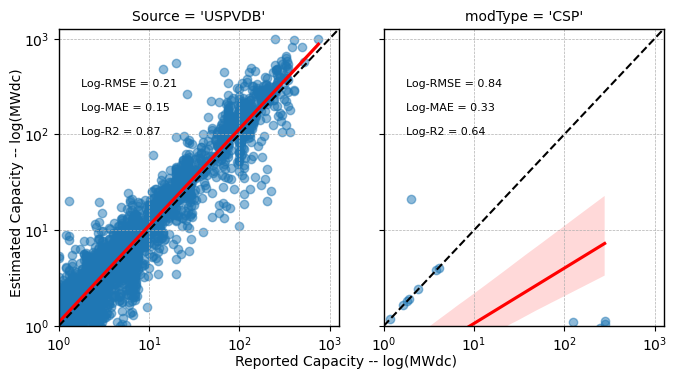

In [ ]:
# Call gmseusArrays and CCVPV arrays
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# First version of plotdf (Source = 'USPVDB')
plotdf1 = gmseusArrays[gmseusArrays['Source'].isin(['USPVDB'])]
plotdf1['capMW'] = np.log10(plotdf1['capMW'])
plotdf1['capMWest'] = np.log10(plotdf1['capMWest'])

# Second version of plotdf (modType = 'CSP')
plotdf2 = gmseusArrays[gmseusArrays['modType'] == 'csp']
plotdf2['capMW'] = np.log10(plotdf2['capMW'])
plotdf2['capMWest'] = np.log10(plotdf2['capMWest'])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Calculate statistics and plot
fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=True, sharey=True)  # Side-by-side plots

# Function to plot regression plots with statistics
def regression_with_stats(ax, data, title):
    # Regression plot with confidence interval
    sns.regplot(x='capMW', y='capMWest', data=data, ax=ax, scatter_kws={'alpha': 0.5}, 
                line_kws={'color': 'red'}, ci=95)
    
    # 1:1 line
    ax.plot([0, 3.1], [0, 3.1], color='black', linestyle='--', label='1:1 Line')
    
    # Grid and styling
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Calculate statistics
    rmse = np.sqrt(((data['capMW'] - data['capMWest'])**2).mean())
    mae = (data['capMW'] - data['capMWest']).abs().mean()
    r2 = 1 - ((data['capMW'] - data['capMWest'])**2).sum() / ((data['capMW'] - data['capMW'].mean())**2).sum()
    
    # Add statistics text
    ax.text(0.25, 2.5, f'Log-RMSE = {rmse:.2f}', fontsize=8)
    ax.text(0.25, 2.25, f'Log-MAE = {mae:.2f}', fontsize=8)
    ax.text(0.25, 2.00, f'Log-R2 = {r2:.2f}', fontsize=8)
    
    # Axes limits and title
    ax.set_xlim(0, 3.1)
    ax.set_ylim(0, 3.1)
    ax.set_title(title, fontsize=10)
    
    # Log-scale ticks
    def log_tick_formatter(val, pos):
        return f"$10^{{{int(val)}}}$"

    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

    # Full box around the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)

    # Drop x and y titles
    ax.set_xlabel('')
    ax.set_ylabel('')

# Plot first dataframe
regression_with_stats(axes[0], plotdf1, "Source = 'USPVDB'")

# Plot second dataframe
regression_with_stats(axes[1], plotdf2, "modType = 'CSP'")

# Common axis labels
fig.text(0.5, 0.04, 'Reported Capacity -- log(MWdc)', ha='center', fontsize=10)
fig.text(0.02, 0.5, 'Estimated Capacity -- log(MWdc)', va='center', rotation='vertical', fontsize=10)

# Adjust layout and save
plt.tight_layout(pad=2.0)
plt.savefig(os.path.join(figure_path, 'capacityValidation_side_by_side.png'), dpi=300, bbox_inches='tight')
plt.show()

## Ground Cover Ratio

               GCR1    GCR2
mount                      
dual_axis    0.6155  0.6265
fixed_axis   0.5332  0.5572
mixed        0.4682  0.5430
single_axis  0.4308  0.5147
mount
fixed_axis     5479
mixed          1438
single_axis    1155
dual_axis       355
Name: count, dtype: int64
mount
fixed_axis     639
single_axis    360
Name: count, dtype: int64


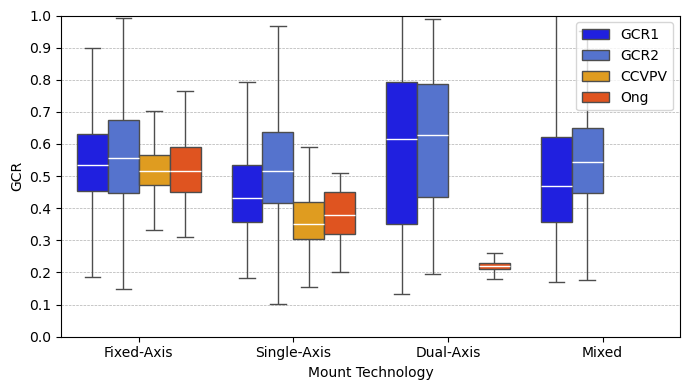

In [41]:
# ~~~~~~~~~~~~~~~~~~~~~~~ GMSEUS

# Call gmseusArrays and CCVPV arrays
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Select gmseusArrays where modType is not csp
#gmseusArrays = gmseusArrays[gmseusArrays['modType'] != 'csp']

# Subset for gmseusArrays where numRow > 0
gmseusArrays = gmseusArrays[gmseusArrays['numRow'] > 0]

# For the purpose of this plot, if mount contains "mixed_", set mount type as mixed
gmseusArrays.loc[gmseusArrays['mount'].str.contains('mixed_'), 'mount'] = 'mixed'

# Print median GCR1 and GCR2 values for each mount type
print(gmseusArrays.groupby('mount')[['GCR1', 'GCR2']].median())

# Melt GCR1 and GCR2 from gmseusArrays for plotting
gcr_melted = gmseusArrays.melt(
    id_vars='mount',
    value_vars=['GCR1', 'GCR2'],
    var_name='Dataset',
    value_name='Value')

# Print the number of arrays with each mount type
print(gmseusArrays['mount'].value_counts())

# ~~~~~~~~~~~~~~~~~~~~~~~ CCVPV

# Call ccvpvArrays
ccvpv = gpd.read_file(ccvpvInitArraysPath)

# Drop erronous PF values (< 0 and > 1)
ccvpv = ccvpv[(ccvpv['PF'] >= 0) & (ccvpv['PF'] <= 1)]

# Set a mount column. If Class is 'Si_Fixed_S', set to fixed_axis. If Class is 'Si_Single_E/W', set to single_axis. 
ccvpv['mount'] = np.nan
ccvpv['mount'] = ccvpv['mount'].astype(object)
ccvpv.loc[ccvpv['Class'] == 'Si_Fixed_S', 'mount'] = 'fixed_axis'
ccvpv.loc[ccvpv['Class'] == 'Si_Single_E/W', 'mount'] = 'single_axis'

# Melt PF values from ccvpvArrays for plotting
ccvpv_melted = ccvpv.melt(
    id_vars='mount',
    value_vars=['PF'],
    var_name='Dataset',
    value_name='Value'
)

# Update the Dataset column to label PF data
ccvpv_melted['Dataset'] = 'CCVPV'

# Print the number of arrays with each mount type
print(ccvpv['mount'].value_counts())

# ~~~~~~~~~~~~~~~~~~~~~~~ Ong et al., 2013

# Define the Ong et al., 2013 boxplot statistics
ong_data = {
    'mount': ['fixed_axis', 'single_axis', 'dual_axis'],
    'Min': [0.31, 0.20, 0.13],
    'Q1': [0.45, 0.32, 0.21],
    'Median': [0.51, 0.36, 0.22],
    'Q3': [0.59, 0.45, 0.23],
    'Max': [0.92, 0.51, 0.32]}
ong_df = pd.DataFrame(ong_data)

# Function to generate synthetic data based on boxplot statistics
def generate_synthetic_data(row, size=100):
    min_val, q1, median, q3, max_val = row['Min'], row['Q1'], row['Median'], row['Q3'], row['Max']
    lower_whisker = np.random.uniform(min_val, q1, size // 4)  # Values between Min and Q1
    iqr = np.random.uniform(q1, q3, size // 2)                # Values between Q1 and Q3
    upper_whisker = np.random.uniform(q3, max_val, size // 4) # Values between Q3 and Max
    return np.concatenate([lower_whisker, iqr, upper_whisker])

# Generate synthetic data for each mount type in Ong's dataset
synthetic_ong_data = []
for _, row in ong_df.iterrows():
    data = generate_synthetic_data(row)
    synthetic_ong_data.append(pd.DataFrame({
        'mount': row['mount'],
        'Value': data,
        'Dataset': 'Ong'}))

# Combine synthetic Ong data into a single DataFrame
synthetic_ong_df = pd.concat(synthetic_ong_data, ignore_index=True)

# ~~~~~~~~~~~~~~~~~~~~~~~ Plotting

# Combine the GMSEUS, CCVPV, and Ong et al., 2013 data
combined_df = pd.concat([gcr_melted, ccvpv_melted, synthetic_ong_df], ignore_index=True)

# Plot the combined dataset. Change x-axis names to 'Fixed-Axis', 'Single-Axis', and 'Dual-Axis'.
# Set dataset colors (GCR1: greyblue, GCR2: lightblue, CCVPV: orange, Ong: red). Make boxplot median a white line
plt.figure(figsize=(7, 4))
sns.boxplot(
    x='mount',
    y='Value',
    hue='Dataset',
    data=combined_df,
    palette={'GCR1': 'blue', 'GCR2': 'royalblue', 'CCVPV': 'orange', 'Ong': 'orangered'},
    showfliers=False,
    order=['fixed_axis', 'single_axis', 'dual_axis', 'mixed'], 
    medianprops={'color': 'white'})

# Set x-axis names
plt.xticks(ticks=[0, 1, 2, 3], labels=['Fixed-Axis', 'Single-Axis', 'Dual-Axis', 'Mixed'])

# Set y-axis limits
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))  # Set ticks from 0 to 1 in steps of 0.1

# Add title and labels
plt.xlabel('Mount Technology')
plt.ylabel('GCR')
plt.legend(loc='upper right')

# Add horizontal grid lines
plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
#plt.show()

# Save the plot
plt.savefig(os.path.join(figure_path, 'GCRValidation.png'), dpi=300)

# Spatial Validation

In [41]:
# Set folder paths
wd = r'S:\Users\stidjaco\R_files\BigPanel'
downloaded_path = os.path.join(wd, r'Data\Downloaded')
derived_path = os.path.join(wd, r'Data\Derived')
derivedTemp_path = os.path.join(derived_path, r'intermediateProducts')

# Set CONUS Shapefile path
CONUS_path = os.path.join(wd, r'Data\Downloaded\CONUS_NoGreatLakes\CONUS_No_Great_Lakes.shp')

# Set existing dataset paths
uspvdb_path = os.path.join(derivedTemp_path, r'uspvdb_poly.shp')
ccvpv_path = os.path.join(derivedTemp_path, r'ccvpv_poly.shp')
cwsd_path = os.path.join(derivedTemp_path, r'cwsd_poly.shp')
osm_path = os.path.join(derivedTemp_path, r'osm_poly.shp')
sam_path = os.path.join(derivedTemp_path, r'sam_poly.shp')

# Call gmseusArrays final
gmseusArrays = gpd.read_file(gmseusArraysFinalPath)

# Set GMSEUS NAIP paths and existing panels path
gmseusNaipArraysPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_NAIP_Arrays.shp')
gmseusNaipPanelsPath = os.path.join(derived_path, r'GMSEUS/GMSEUS_NAIP_Panels.shp')
gmseusPanelsExistingPath = os.path.join(derivedTemp_path, r'initialGMSEUS_Panels.shp')

# Call each array dataset
gmseus = gpd.read_file(gmseusNaipArraysPath)
uspvdb = gpd.read_file(uspvdb_path)
ccvpv = gpd.read_file(ccvpv_path)
cwsd = gpd.read_file(cwsd_path)
osm = gpd.read_file(osm_path)
sam = gpd.read_file(sam_path)

# Call each panel dataset
#gmseusPanelsNAIP = gpd.read_file(gmseusNaipPanelsPath)
#gmseusPanelsExisting = gpd.read_file(gmseusPanelsExistingPath)

## Array IoU

### Get Numbers

In [49]:
# Get the IOU of datasets relative to USPVDB
gmseusIOU = getIoU(uspvdb, gmseus)
ccvpvIOU = getIoU(uspvdb, ccvpv)
cwsdIOU = getIoU(uspvdb, cwsd)
osmIOU = getIoU(uspvdb, osm)
samIOU = getIoU(uspvdb, sam)

# Set dataset names
gmseusIOU['Name'] = 'GM-SEUS'
ccvpvIOU['Name'] = 'CCVPV'
cwsdIOU['Name'] = 'CWSD'
osmIOU['Name'] = 'OSM'
samIOU['Name'] = 'TZ-SAM'

# Get and print number of uspvdb arrays that intersect with GMSEUS
uspvdbGMSEUS = uspvdb[uspvdb.intersects(gmseus.unary_union)]

# Print the number of arrays that intersect with GMSEUS
print(f'The number of USPVDB arrays that intersect with GMSEUS is {len(uspvdbGMSEUS)}')

# Print sum of origArea as a proportion of total USPVDB area
print('GM-SEUS Proportional USPVDB Coverage: ', gmseusIOU['areaA'].sum() / uspvdb['geometry'].area.sum())
print('CCVPV Proportional USPVDB Coverage: ', ccvpvIOU['areaA'].sum() / uspvdb['geometry'].area.sum())
print('CWSD Proportional USPVDB Coverage: ', cwsdIOU['areaA'].sum() / uspvdb['geometry'].area.sum())
print('OSM Proportional USPVDB Coverage: ', osmIOU['areaA'].sum() / uspvdb['geometry'].area.sum())
print('SAM Proportional USPVDB Coverage: ', samIOU['areaA'].sum() / uspvdb['geometry'].area.sum())

# Print median IoU
print('GM-SEUS Median IoU: ', gmseusIOU['IoU'].median())
print('CCVPV Median IoU: ', ccvpvIOU['IoU'].median())
print('CWSD Median IoU: ', cwsdIOU['IoU'].median())
print('OSM Median IoU: ', osmIOU['IoU'].median())
print('SAM Median IoU: ', samIOU['IoU'].median())

# Combine all IoU results into one DataFrame
datasets = [samIOU, osmIOU, cwsdIOU, ccvpvIOU, gmseusIOU]
all_data = pd.concat(datasets, ignore_index=True)

# Print the median proportional difference for each dataset (by name)
print('GM-SEUS Median Proportional Array Area Difference: ', all_data[all_data['Name'] == 'GM-SEUS']['propDiff'].median())
print('CCVPV Median Proportional Array Area Difference: ', all_data[all_data['Name'] == 'CCVPV']['propDiff'].median())
print('CWSD Median Proportional Array Area Difference: ', all_data[all_data['Name'] == 'CWSD']['propDiff'].median())
print('OSM Median Proportional Array Area Difference: ', all_data[all_data['Name'] == 'OSM']['propDiff'].median())
print('SAM Median Proportional Array Area Difference: ', all_data[all_data['Name'] == 'TZ-SAM']['propDiff'].median())

The number of USPVDB arrays that intersect with GMSEUS is 2871
GM-SEUS Proportional USPVDB Coverage:  0.5289417302292837
CCVPV Proportional USPVDB Coverage:  0.035268994631050356
CWSD Proportional USPVDB Coverage:  0.034590670777147114
OSM Proportional USPVDB Coverage:  0.9295435153848175
SAM Proportional USPVDB Coverage:  0.995924305608309
GM-SEUS Median IoU:  0.8759448842141501
CCVPV Median IoU:  0.9473466339895749
CWSD Median IoU:  0.8481808293881659
OSM Median IoU:  0.8257694146091442
SAM Median IoU:  0.6876179547346363
GM-SEUS Median Proportional Array Area Difference:  -0.12041404023896646
CCVPV Median Proportional Array Area Difference:  -0.002181602700142036
CWSD Median Proportional Array Area Difference:  -0.08769773980609018
OSM Median Proportional Array Area Difference:  0.19903375586943572
SAM Median Proportional Array Area Difference:  0.4510401859462611


### Get Figure

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Make the Plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={'width_ratios': [0.4, 0.6]})

# Define line styles and dataset order
line_styles = [':', (0, (1, 1)), '-.', '-', '--']  # Adjusted styles for left to right solidity
dataset_order = ['TZ-SAM', 'OSM', 'CWSD', 'GM-SEUS', 'CCVPV']
#palette = sns.color_palette('Set1', len(dataset_order))  # Define consistent colors
gray_shade = "lightgray"  # Color for boxplots

# Left Plot: Cumulative Distribution Plot (IoU on x-axis)
for i, name in enumerate(dataset_order):
    group = all_data[all_data['Name'] == name]
    sns.ecdfplot(data=group, x="IoU", ax=axes[0], label=name, kinestyle=line_styles[i], color='gray', linewidth=1)

# Add 50% cumulative distribution line
axes[0].axhline(0.5, color='red', linestyle='--', linewidth=0.5) #, label='50% Cumulative'
axes[0].set_xlabel('IoU with USPVDB')
axes[0].set_ylabel('Cumulative Distribution')
#axes[0].set_title('Cumulative IoU Distribution')
#axes[0].legend(loc='center', bbox_to_anchor=(0.25, 0.75), frameon=False, fontsize=8)  # Center legend at (0.25, 0.5)
#axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust legend with no background, font size 8, and text color
legend = axes[0].legend(loc='center', bbox_to_anchor=(0.25, 0.75), frameon=False, fontsize=8)  # Legend text size 8
for text in legend.get_texts():
    text.set_color('#4D4D4D')  # Set legend text color to #4D4D4D

# Add "A" label in the lower left corner
axes[0].text(0.02, 0.02, 'A', transform=axes[0].transAxes, ha='left', va='bottom', fontsize=12, weight='bold')

# Right Plot: Boxplot for Proportional Difference
sns.boxplot(data=all_data, x='Name', y='propDiff', order=dataset_order, 
    boxprops=dict(color=gray_shade),  # Apply gray shade to boxplots
    whiskerprops=dict(color="gray"),  # Make whiskers dark gray
    capprops=dict(color="gray"),  # Make caps dark gray
    medianprops=dict(color="black"),  # Ensure median line is black
    showfliers=False, ax=axes[1])

# Add total sum of areaA and areaB in km² for each dataset
axes[1].text(4, 0.75, f"Ref. Area\nData Area", ha='center', va='center', fontsize=8, color = '#4D4D4D')
for i, name in enumerate(dataset_order):
    total_areaA_km2 = int(round(all_data[all_data['Name'] == name]['areaA'].sum() / 1e6, 0))
    total_areaB_km2 = int(round(all_data[all_data['Name'] == name]['areaB'].sum() / 1e6, 0))
    axes[1].text(i, -0.75, f"{total_areaA_km2} km²\n{total_areaB_km2} km²", ha='center', va='center', fontsize=8, color = '#4D4D4D')

# Add labels, title, and set y-axis limits
axes[1].axhline(0, color='red', linestyle='--', linewidth=0.5)  # Add a reference line at 0
axes[1].set_ylim(-1.25, 1.25)  # Set limits from -1.25 to 1.25
#axes[1].set_title('Proportional Array Area Difference by Dataset')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Prop. Area Diff. (USPVDB)')
#axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add "A" label in the lower left corner
axes[1].text(0.02, 0.02, 'B', transform=axes[1].transAxes, ha='left', va='bottom', fontsize=12, weight='bold')

# Change axis text to dark gray
for ax in axes:
    ax.tick_params(axis='x', colors='#4D4D4D')  # Set x-axis tick labels to dark gray
    ax.tick_params(axis='y', colors='#4D4D4D')  # Set y-axis tick labels to dark gray

# Adjust layout
plt.tight_layout(pad=2.0)  # Add padding between subplots
plt.subplots_adjust(wspace=0.3)  # Increase spacing between the two plots

# Save the figure
plt.savefig(os.path.join(figure_path, 'IoU_ProportionalDifference.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'IoU_ProportionalDifference.pdf'), dpi=300, bbox_inches='tight')

# Adjust layout and display
#plt.tight_layout()
plt.show()

## Panel-Rows IoU

### Get Numbers

In [ ]:
# Get the IOU of NAIP panels relative to existing
naipPanelsIOU = getIoU(gmseusPanelsExisting, gmseusPanelsNAIP, True)

# Set name
naipPanelsIOU['Name'] = 'NAIP Panel-Rows'

# Print median IoU
print('GM-SEUS NAIP Median IoU: ', naipPanelsIOU['IoU'].median())

# Print the median proportional difference for NAIP panels
print('GM-SEUS NAIP Median Proportional Panel Area Difference: ', naipPanelsIOU['propDiff'].median())

# Print the length of naipPanelsIOU
print('Number of Intersections in naipPanelsIOU: ', len(naipPanelsIOU))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Get arrays from panels

# Now, we need to create array from panels, selecting intersecting new arrays (we've already done this for NAIP panels)
naipArraysFromPanels = gpd.read_file(gmseusNaipArraysPath)

# Now, add a pnlIntersectID column to naipArraysFromPanels
naipArraysFromPanels['pnlIntersectID'] = range(1, len(naipArraysFromPanels) + 1) 

# Address existing panels
# Set the rowArea column to the area of the panel
# Spatially join gmseus arrays to panels, copy the pnlIntersectID to the panels, and drop the index columns. 
gmseusPanelsExisting = gmseusPanelsExisting.drop(columns=['pnlIntersectID', 'rowArea'], errors='ignore')
gmseusPanelsExisting['rowArea'] = gmseusPanelsExisting['geometry'].area
gmseusPanelsExisting = gpd.sjoin(gmseusPanelsExisting, naipArraysFromPanels[['pnlIntersectID', 'geometry']], how='left', predicate='intersects')
gmseusPanelsExisting  = gmseusPanelsExisting.reset_index(drop=True)
gmseusPanelsExisting  = gmseusPanelsExisting.drop(columns=['index_left', 'index_right'], errors='ignore')
existingArraysFromPanels = createArrayFromPanels(gmseusPanelsExisting, panelArrayBuff, 'pnlIntersectID', 'rowArea')

# Now create a new gdf comparePanelArea with pnlIntersectID, area, and nativeID
naipArraysFromPanels = naipArraysFromPanels[['pnlIntersectID', 'pnlArea']]
naipArraysFromPanels = naipArraysFromPanels.rename(columns = {'pnlArea': 'pnlAreaNAIP'})
existingArraysFromPanels = existingArraysFromPanels[['pnlIntersectID', 'pnlArea']]
comparePanelArea = naipArraysFromPanels.merge(existingArraysFromPanels, on = 'pnlIntersectID', how = 'left')

# Add a propDiff column to comparePanelArea and a Name column
comparePanelArea['propDiff'] = (comparePanelArea['pnlAreaNAIP'] - comparePanelArea['pnlArea']) / comparePanelArea['pnlArea']
comparePanelArea['Name'] = 'NAIP Panel-Rows'

GM-SEUS NAIP Median IoU:  0.475423832376628
GM-SEUS NAIP Median Proportional Panel Area Difference:  0.14976009376243393
Number of Intersections in naipPanelsIOU:  361174


### Get Figure

f:\Python_Envs\BigPanel\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


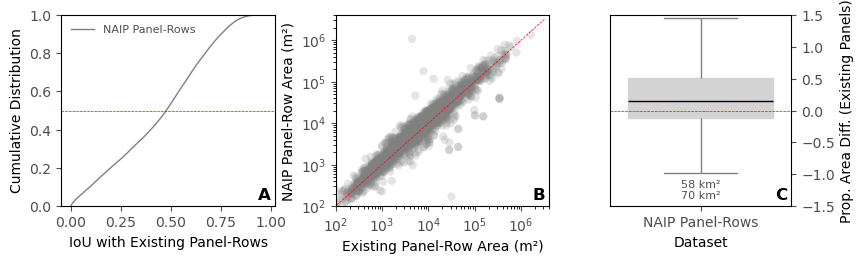

In [97]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Make the Plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(9, 3), gridspec_kw={'width_ratios': [1, 1, 0.85]})

# Define line style and color
line_style = '-'
line_color = 'gray'
gray_shade = "lightgray"

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Subplot A

# Left Plot: Cumulative Distribution Plot (IoU on x-axis)
sns.ecdfplot(data=naipPanelsIOU, x="IoU", ax=axes[0], label='NAIP Panel-Rows', linestyle=line_style, color=line_color, linewidth=1)

# Add 50% cumulative distribution line
axes[0].axhline(0.5, color='red', linestyle='--', linewidth=0.5)
axes[0].set_xlabel('IoU with Existing Panel-Rows')
axes[0].set_ylabel('Cumulative Distribution')

# Adjust legend with no background, font size 8, and text color
legend = axes[0].legend(loc='upper left', frameon=False, fontsize=8)
for text in legend.get_texts():
    text.set_color('#4D4D4D')  # Set legend text color to #4D4D4D

# Add "A" label in the lower left corner
axes[0].text(0.98, 0.02, 'A', transform=axes[0].transAxes, ha='right', va='bottom', fontsize=12, weight='bold')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Subplot B

# Right Plot: Scatterplot for areaA (x) and areaB (y) in log-log scale (I want no edge color)
axes[1].scatter(comparePanelArea['pnlArea'], comparePanelArea['pnlAreaNAIP'], alpha=0.2, edgecolors='none', color='gray')

# Add reference line (y=x) for comparison
max_val = max(comparePanelArea['pnlArea'].max(), comparePanelArea['pnlAreaNAIP'].max())
min_val = min(comparePanelArea['pnlArea'].min(), comparePanelArea['pnlAreaNAIP'].min())
axes[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=0.5)

# Set log-log scale
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# Add labels, title, and format axes
axes[1].set_xlabel('Existing Panel-Row Area (m²)')
axes[1].set_ylabel('NAIP Panel-Row Area (m²)')
axes[1].set_xlim([1e2, max_val * 1.2])  # Adjust limits to fit data
axes[1].set_ylim([1e2, max_val * 1.2])

# Add "B" label in the upper left
axes[1].text(0.98, 0.02, 'B', transform=axes[1].transAxes, ha='right', va='bottom', fontsize=12, weight='bold')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Subplot C

# Right Plot: Boxplot for Proportional Difference
sns.boxplot(
    data=naipPanelsIOU,
    x='Name',
    y='propDiff',
    boxprops=dict(color=gray_shade),  # Apply gray shade to boxplots
    whiskerprops=dict(color="gray"),  # Make whiskers dark gray
    capprops=dict(color="gray"),  # Make caps dark gray
    medianprops=dict(color="black"),  # Ensure median line is black
    showfliers=False,
    ax=axes[2])

# Add total sum of pnlArea and pnlAreaNAIP in km²
total_areaA_km2 = int(round(naipPanelsIOU['areaA'].sum() / 1e6, 0))
total_areaB_km2 = int(round(naipPanelsIOU['areaB'].sum() / 1e6, 0))
axes[2].text(0, -1.25, f"{total_areaA_km2} km²\n{total_areaB_km2} km²", ha='center', va='center', fontsize=8, color='#4D4D4D')

# Add labels, title, and set y-axis limits
axes[2].axhline(0, color='red', linestyle='--', linewidth=0.5)  # Add a reference line at 0
axes[2].set_ylim(-1.5, 1.5)  # Set limits from -1.5 to 1.5
axes[2].set_ylabel('')  # Remove default y-axis label
axes[2].yaxis.tick_right()  # Move y-axis ticks to the right
axes[2].yaxis.set_label_position('right')  # Move y-axis label to the right
axes[2].set_ylabel('Prop. Area Diff. (Existing Panels)')  # Add y-axis label on the right
axes[2].set_xlabel('Dataset')

# Add "B" label in the upper left
axes[2].text(0.98, 0.02, 'C', transform=axes[2].transAxes, ha='right', va='bottom', fontsize=12, weight='bold')

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Adjust layout

# Change axis text to dark gray
for ax in axes:
    ax.tick_params(axis='x', colors='#4D4D4D')  # Set x-axis tick labels to dark gray
    ax.tick_params(axis='y', colors='#4D4D4D')  # Set y-axis tick labels to dark gray

# Adjust layout. I want plot a and b to be normally spaced and plot b and C to be touching
plt.tight_layout(pad=2.0)  # Add padding between subplots
plt.subplots_adjust(wspace=0.3)  # Increase spacing between the two plot

# # Save the figure
plt.savefig(os.path.join(figure_path, 'PanelRows_IoU_ProportionalDifference.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'PanelRows_IoU_ProportionalDifference.pdf'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [79]:
# Now, we need to create array from panels, selecting intersecting new arrays (we've already done this for NAIP panels)
naipArrays = gpd.read_file(gmseusNaipArraysPath)

# Print head of comparePanelArea where propDiff is greater than 200
print(comparePanelArea[comparePanelArea['propDiff'] > 200])

# Get pnlAreaNAIP of comparePanelArea where propDiff is greater than 200
largePnlArea = int(comparePanelArea[comparePanelArea['propDiff'] > 200]['pnlAreaNAIP'])

# Subset naipArrays for where pnlArea is == largePnlArea
testArray = naipArrays[naipArrays['pnlArea'] == largePnlArea]

# Print head
print(testArray.head())


      pnlIntersectID   pnlAreaNAIP      pnlArea    propDiff             Name
4901            4902  1.073086e+06  4421.869842  241.676985  NAIP Panel-Rows
Empty GeoDataFrame
Columns: [subArrID, arrayID, nativeID, Source, pnlNum, area, mount, azimuth, lengthRati, shortEdge, longEdge, QAQC, perimeter, PmArRatio, compactnes, areaRatio, numPanels, pnlArea, arrayArea, geometry]
Index: []


C:\Users\stidjaco\AppData\Local\Temp\ipykernel_37560\776975546.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  largePnlArea = int(comparePanelArea[comparePanelArea['propDiff'] > 200]['pnlAreaNAIP'])
